# LCMV Source Estimation with `lcmv_class.py`
### *A single-subject tutorial for 280-channel EGI EEG data*

This notebook demonstrates how to:
 - Load **ICA-cleaned EEG** (from your `ica_xtra` pipeline)
 - Perform **enhanced coregistration** using `.gpsc` fiducials
 - Compute **LCMV beamformer** on continuous data
 - Extract **DiFuMo 512-component time courses**
 - Save all outputs for downstream analysis




In [4]:
# 📦 Requirements 
# pip install mne matplotlib
# pip install pandas tqdm  joblib
# pip install nilearn nibabel 


## 🧪 Step 1: Import and Configure

In [ ]:

from lcmv_class import LCMVSourceEstimator

# Define paths for ONE subject
PROJECT_BASE = "."                
SUBJECT_ID = "sub-01"           
TASK = "eyes_closed"            # ← match your actual task name

# Point to your ICA-cleaned FIF (output from ica_xtra pipeline)
ICA_FILE_PATH = "sub-01_eyes_closed_ica_cleaned.fif"
GPS_FILE_PATH = "ghw280_from_egig.gpsc"

# Build config
config = {
    'project_base': PROJECT_BASE,
    'subject_id': SUBJECT_ID,
    'task': TASK,
    'ica_file_path': ICA_FILE_PATH,
    'gpsc_file_path': GPS_FILE_PATH,
    'reg': 0.01,        # Regularization for LCMV
    'n_jobs': 4,        # Parallelism for MNE internals
}


## ▶️ Step 2: Run LCMV Source Estimation

In [ ]:
estimator = LCMVSourceEstimator(config)
metadata = estimator.run_enhanced_computation()

print("\n✅ LCMV completed! Outputs saved to:")
print(f"   {estimator.subject_output}")

## 🔍 Step 3: Extract Atlas Time Courses

In [ ]:
# Only run if you want functional network time series (atlas parcelation)
USE_DIFUMO = True

if USE_DIFUMO:
    difumo_config = {
        'dimension': 512,
        'resolution_mm': 2
    }
    time_courses, comp_info = estimator.run_difumo_extraction(difumo_config=difumo_config)

    print(f"\n📊 DiFuMo output shape: {time_courses.shape}")
    print("   → 512 components × time points")
    print(f"   Saved to: {estimator.subject_output / 'difumo_time_courses.npy'}")



## 📁 Step 4: Inspect Output Files

In [ ]:
estimator.list_output_files();

## 🌈 Step 5: Visualize PSD regions of interest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from nilearn import datasets

def plot_psd_rois(file_path, roi_indices, sfreq=500.0, figsize=(9, 4),cmap=plasma):
    """
    Plot PSD for selected DiFuMo ROIs from an LCMV time course file.
    
    Parameters:
    -----------
    file_path : str
        Path to 'difumo_time_courses.npy'
    roi_indices : list of int
        DiFuMo indices (e.g., [305, 437, 223])
    sfreq : float, optional
        Sampling frequency (default: 500.0 Hz)
    figsize : tuple, optional
        Figure size (default: (9, 4))
    """
    
    # 📥 Load data
    data = np.load(file_path)
    if data.shape[0] != 512:
        data = data.T  # ensure (512, n_times)

    # 🧠 Load labels
    labels = datasets.fetch_atlas_difumo(512, 2).labels['difumo_names'].tolist()

    # 🎨 ROI colors (you can keep plasma or switch)
    cmap = plasma
    colors = plt.cm.cmap(np.linspace(0, 1, len(roi_indices)))

    # 📊 Compute PSDs
    fig, ax = plt.subplots(figsize=figsize)
    freqs = None

    for i, idx in enumerate(roi_indices):
        ts = data[idx]
        freqs, psd = signal.welch(ts, fs=sfreq, nperseg=int(1.5 * sfreq))
        psd_db = 10 * np.log10(psd)
        name = labels[idx].strip()
        ax.plot(freqs, psd_db, label=name, color=colors[i], linewidth=2)

    # 🔊 Frequency bands — now with BLUE GRADIENT
    FREQ_BANDS = [
        ('Delta', (0, 4)),
        ('Theta', (4, 8)),
        ('Alpha', (8, 12)),
        ('Low_Beta', (12, 20)),
        ('High_Beta', (20, 30)),
        ('Low_Gamma', (30, 50)),
        ('High_Gamma', (50, 120))
    ]

    # 🌊 Generate 7 shades of blue: light → dark
    blue_shades = plt.cm.Blues(np.linspace(0.9, 0.2, len(FREQ_BANDS)))  # avoid too-light start
    band_colors = {band: blue_shades[i] for i, (band, _) in enumerate(FREQ_BANDS)}

    # 🎨 Shade bands (no labels)
    if freqs is not None:
        for band, (fmin, fmax) in FREQ_BANDS:
            if fmax < freqs[0] or fmin > freqs[-1]:
                continue
            ax.axvspan(fmin, fmax, color=band_colors[band], alpha=0.3, zorder=0)

    # 🖋️ Styling
    ax.set_xlim(0, 120)
    ax.set_ylim(-70, -10)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectral Density (dB/Hz)")
    ax.set_title("Source-Level PSD (LCMV + DiFuMo)", fontweight='bold')
    ax.grid(True, alpha=0.1)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.8)
    plt.tight_layout()
    
    return fig

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from nilearn import datasets

def plot_psd_rois(file_path, roi_indices, sfreq=500.0, figsize=(9, 4), cmap_name='plasma'):
    """
    Plot PSD for selected DiFuMo ROIs from an LCMV time course file.
    
    Parameters:
    -----------
    file_path : str
        Path to 'difumo_time_courses.npy'
    roi_indices : list of int
        DiFuMo indices (e.g., [305, 437, 223])
    sfreq : float, optional
        Sampling frequency (default: 500.0 Hz)
    figsize : tuple, optional
        Figure size (default: (9, 4))
    cmap_name : str or matplotlib colormap, optional
        Colormap to use for ROI colors (default: 'plasma')
    """
    
    # 📥 Load data
    data = np.load(file_path)
    if data.shape[0] != 512:
        data = data.T  # ensure (512, n_times)

    # 🧠 Load labels
    labels = datasets.fetch_atlas_difumo(512, 2).labels['difumo_names'].tolist()

    # 🎨 ROI colors
    cmap = plt.cm.get_cmap(cmap_name)  # safely get colormap
    colors = cmap(np.linspace(0, 1, len(roi_indices)))

    # 📊 Compute PSDs
    fig, ax = plt.subplots(figsize=figsize)
    freqs = None

    for i, idx in enumerate(roi_indices):
        ts = data[idx]
        freqs, psd = signal.welch(ts, fs=sfreq, nperseg=int(1.5 * sfreq))
        psd_db = 10 * np.log10(psd)
        name = labels[idx].strip()
        ax.plot(freqs, psd_db, label=name, color=colors[i], linewidth=2)

    # 🔊 Frequency bands — now with BLUE GRADIENT
    FREQ_BANDS = [
        ('Delta', (0, 4)),
        ('Theta', (4, 8)),
        ('Alpha', (8, 12)),
        ('Low_Beta', (12, 20)),
        ('High_Beta', (20, 30)),
        ('Low_Gamma', (30, 50)),
        ('High_Gamma', (50, 120))
    ]

    # 🌊 Generate 7 shades of blue: light → dark
    blue_shades = plt.cm.Blues(np.linspace(0.9, 0.2, len(FREQ_BANDS)))
    band_colors = {band: blue_shades[i] for i, (band, _) in enumerate(FREQ_BANDS)}

    # 🎨 Shade bands (no labels)
    if freqs is not None:
        for band, (fmin, fmax) in FREQ_BANDS:
            if fmax < freqs[0] or fmin > freqs[-1]:
                continue
            ax.axvspan(fmin, fmax, color=band_colors[band], alpha=0.3, zorder=0)

    # 🖋️ Styling
    ax.set_xlim(0, 120)
    ax.set_ylim(-70, -10)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectral Density (dB/Hz)")
    ax.set_title("Source-Level PSD (LCMV + DiFuMo)", fontweight='bold')
    ax.grid(True, alpha=0.1)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.8)
    plt.tight_layout()
    
    return fig

[fetch_atlas_difumo] Dataset found in C:\Users\yucca\nilearn_data\difumo_atlases


C:\Users\yucca\AppData\Local\Temp\ipykernel_7300\1851222175.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)  # safely get colormap


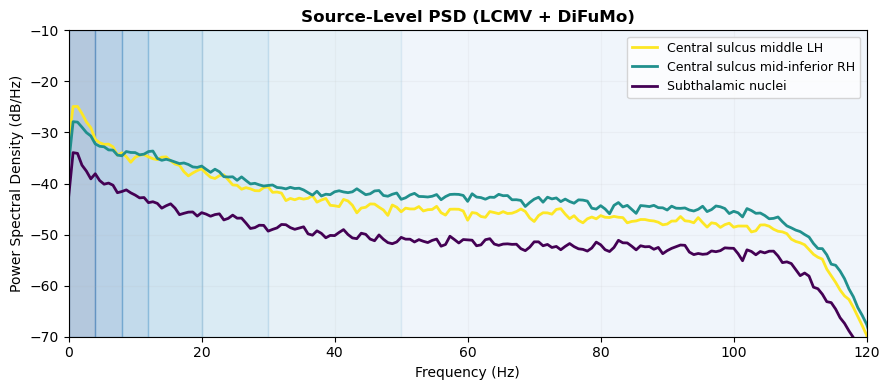

In [ ]:
# Select the indices
fig = plot_psd_rois(
    file_path=r"derivatives\lcmv\sub-01_rest\difumo_time_courses.npy",
    roi_indices=[305, 437, 223],
    cmap_name = 'viridis_r'               #    <------ Select the roi color
)
plt.show()

# 💡 How It Works 

 1. **Load ICA-cleaned FIF** → already has 281 channels, montage, and reference
 2. **Enhanced coregistration**:
    - Uses `.gpsc` fiducials (`FidNz`, `FidT9`, `FidT10`)
    - Normalizes electrode positions
    - Fits ICP with outlier rejection
 3. **Volume source space**:
    - Uses `fsaverage` (downloaded to global dir)
    - 5mm grid → ~8k sources
 4. **LCMV beamformer**:
    - Single covariance from full recording (`method='oas'`)
    - Proper rank handling for average reference (`rank='info'`)
 5. **DiFuMo extraction**:
    - Maps sources to 512 functional parcels
    - Weighted average using probabilistic atlas
    - Outputs: `(512, n_times)` time series